# Time Series Forecasting using Long Short-Term Memory (LSTM)

***

Long short-term memory (LSTM) is a special type of recurrent neural network that is optimally suited for sequential data. This model takes advantage of time series autocorrelation and is able to remember patterns in the data over the length of the series. This method was first introduced by [Hochreiter & Schmidhuber (1997)](http://www.bioinf.jku.at/publications/older/2604.pdf). **The goals of this tutorial are to build a multi-step LSTM neural network using the [Keras](https://keras.io/) deep learning API to forecast sea surface temperature in the North Pacific.** 

Data: [NOAA's Optimum Interpolation Sea Surface Temperature](https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oisst.v2.highres.html) dataset consists of daily sea surface temperature measurements (ºC) from 1981-09-01 to 2018-06-11. We will be using four time series in the eastern North Pacific.

***

Creator: Hillary Scannell, University of Washington, scanh@uw.edu

Created: 2018-07-03

***

#### Set Up Python Environment
First we will need to set up our Python environment for deep learning. To do this we will be using Anaconda. If you haven't already, you can download the Windows, OSX, or Linux version of Anaconda [here](https://www.anaconda.com/download/#macos). Make sure you choose Python (>=3.3). After installation, you will want to make sure everything is up-to-date with these commands at the terminal:
```
conda update conda
conda update anaconda
conda install scikit-learn
conda update scikit-learn 
```
To use the Keras API, we also need to install either Theano or TensorFlow backend.
```
conda install theano
conda install -c conda-forge tensorflow
pip install keras
```

Next we will import the Python libraries used in this tutorial. If you have probems importing any of these modules, you may not have them installed on your machine. 

In [212]:
# Import Python Libraries
import numpy as np
import os, time, datetime
from datetime import date
import pandas as pd
from pandas import DataFrame, Series, concat
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from marineHeatWaves import detect
import seaborn as sns
import time
from numpy import concatenate

#### Import Data
There are four time series of sea surface temperature (SST) contained in seperate netCDF files. The code below extracts the data from the data files using the indexing parameter *f*. Change the path (*fp*) to match the file directory on your machine and choose *f* values from 0 to 3 to change files. 

In [213]:
files = ['30n120w.nc', '30n140w.nc', '40n160w.nc', '50n140w.nc'] 
f = 3 # index to files  <- choose to analyze a different time series by changing f from 0 to 3

lat = files[f][0:2]
lon = files[f][3:6]
print('Location: ' + lat + 'ºN,' + lon + 'ºS')

Location: 50ºN,140ºS


**Sea Surface Temperature (deg-C)**

In [214]:
fp = '/Users/hscannell/Desktop/data/SST_daily_time_series/' # <- change this to your path
data_files = Dataset(fp + 'sst_' + files[f]) # reading the netCDF file and creating a dataset
for c, value in enumerate(data_files.variables):
    print(data_files[value].name, data_files[value].dimensions, data_files[value].size) 
    
# SST (deg-C)   
SST = np.squeeze(data_files.variables['sst'][:])

# Time (days since)
f_time = data_files.variables['time'][:] # time is given in days since 1800-01-01 00:00:00
ref = datetime.date(1800, 1, 1).toordinal()
sst_time = ref + f_time # adjust time as days since 0000-01-01 00:00:00

# Dates (yyyy-mm-dd)
sst_dates = [date.fromordinal(tt.astype(int)) for tt in sst_time]
sst_dates = np.array(sst_dates)

# Create a python series
sst = pd.Series(SST)
print(sst.head())
print(sst_dates[0],sst_dates[-1])

lat ('lat',) 1
lon ('lon',) 1
sst ('time', 'lat', 'lon') 13433
time ('time',) 13433
0    14.740000
1    15.290000
2    12.349999
3    12.270000
4    12.570000
dtype: float32
1981-09-01 2018-06-11


**Surface Air Temperature (deg-C)**

In [215]:
fp = '/Users/hscannell/Desktop/data/NCEP/ftp.cdc.noaa.gov/Datasets/ncep_timeseries/'
data_files = Dataset(fp + 'airt_' + files[f]) # reading the netCDF file and creating a dataset
for c, value in enumerate(data_files.variables):
    print(data_files[value].name, data_files[value].dimensions, data_files[value].size) 
    
# Air Temperature (Kelvin > Celsius)   
airt = np.squeeze(data_files.variables['air'][:])
airt = airt - 273.15

# Time (days since). Do this once because all atmospheric variables have the same time 
f_time = data_files.variables['time'][:] # time is given in days since 1-1-1 00:00:0.0
ref = datetime.date(1, 1, 1).toordinal()
atmo_time = ref + f_time # adjust time as days since 0000-01-01 00:00:00

# Index into the atmospheric data where it aligns with the SST data
ind0 = int(np.where(atmo_time == sst_time[0])[0])
ind00 = int(np.where(atmo_time == sst_time[-1])[0])

# Dates (yyyy-mm-dd)
atmo_dates = [date.fromordinal(tt.astype(int)) for tt in atmo_time]
atmo_dates = np.array(atmo_dates[ind0:ind00+1])
atmo_time = np.array(atmo_time[ind0:ind00+1])
# Create a python series
airt = pd.Series(airt[ind0:ind00+1])
print(airt.head())

print(len(airt),'and ',len(atmo_dates),'and ',len(atmo_time))
print(atmo_dates[0],atmo_dates[-1])

air ('time', 'lat', 'lon') 13692
lat ('lat',) 1
lon ('lon',) 1
time ('time',) 13692
0    16.160004
1    16.040009
2    15.930023
3    15.809998
4    15.699982
dtype: float32
13433 and  13433 and  13433
1981-09-01 2018-06-11


**Relative Humidity (%)**

In [216]:
fp = '/Users/hscannell/Desktop/data/NCEP/ftp.cdc.noaa.gov/Datasets/ncep_timeseries/'
data_files = Dataset(fp + 'rhum_' + files[f]) # reading the netCDF file and creating a dataset
for c, value in enumerate(data_files.variables):
    print(data_files[value].name, data_files[value].dimensions, data_files[value].size) 
    
# Relative Humidity (%)   
rhum = np.squeeze(data_files.variables['rhum'][:])

# Create a python series
rhum = pd.Series(rhum[ind0:ind00+1])
print(rhum.head())

lat ('lat',) 1
lon ('lon',) 1
rhum ('time', 'lat', 'lon') 13692
time ('time',) 13692
0    69.679993
1    70.529999
2    71.380005
3    72.240005
4    73.089996
dtype: float32


**Sea Level Pressure (mb)**

In [217]:
fp = '/Users/hscannell/Desktop/data/NCEP/ftp.cdc.noaa.gov/Datasets/ncep_timeseries/'
data_files = Dataset(fp + 'slp_' + files[f]) # reading the netCDF file and creating a dataset
for c, value in enumerate(data_files.variables):
    print(data_files[value].name, data_files[value].dimensions, data_files[value].size) 
    
# Relative Humidity (%)   
slp = np.squeeze(data_files.variables['slp'][:])

# Create a python series
slp = pd.Series(slp[ind0:ind00+1])
print(slp.head())

lat ('lat',) 1
lon ('lon',) 1
slp ('time', 'lat', 'lon') 13692
time ('time',) 13692
0    1015.290039
1    1014.330017
2    1013.369995
3    1012.410034
4    1011.450012
dtype: float32


**Wind Speed (m/s)**

In [218]:
fp = '/Users/hscannell/Desktop/data/NCEP/ftp.cdc.noaa.gov/Datasets/ncep_timeseries/'
data_files = Dataset(fp + 'uwnd_' + files[f]) # reading the netCDF file and creating a dataset
for c, value in enumerate(data_files.variables):
    print(data_files[value].name, data_files[value].dimensions, data_files[value].size) 
    
# u-wind (zonal) 
uwnd = np.squeeze(data_files.variables['uwnd'][:])

data_files = Dataset(fp + 'vwnd_' + files[f]) # reading the netCDF file and creating a dataset
for c, value in enumerate(data_files.variables):
    print(data_files[value].name, data_files[value].dimensions, data_files[value].size) 
    
# v-wnd (meridional)
vwnd = np.squeeze(data_files.variables['vwnd'][:])

# Create a python series for wind speed
transform_wind = np.sqrt(np.square(uwnd) + np.square(vwnd))
ws = pd.Series(transform_wind[ind0:ind00+1])
print(ws.head()) 

lat ('lat',) 1
lon ('lon',) 1
time ('time',) 13692
uwnd ('time', 'lat', 'lon') 13692
lat ('lat',) 1
lon ('lon',) 1
time ('time',) 13692
vwnd ('time', 'lat', 'lon') 13692
0    3.181000
1    1.823326
2    2.280365
3    3.976980
4    5.928382
dtype: float32


### Plot Time Series

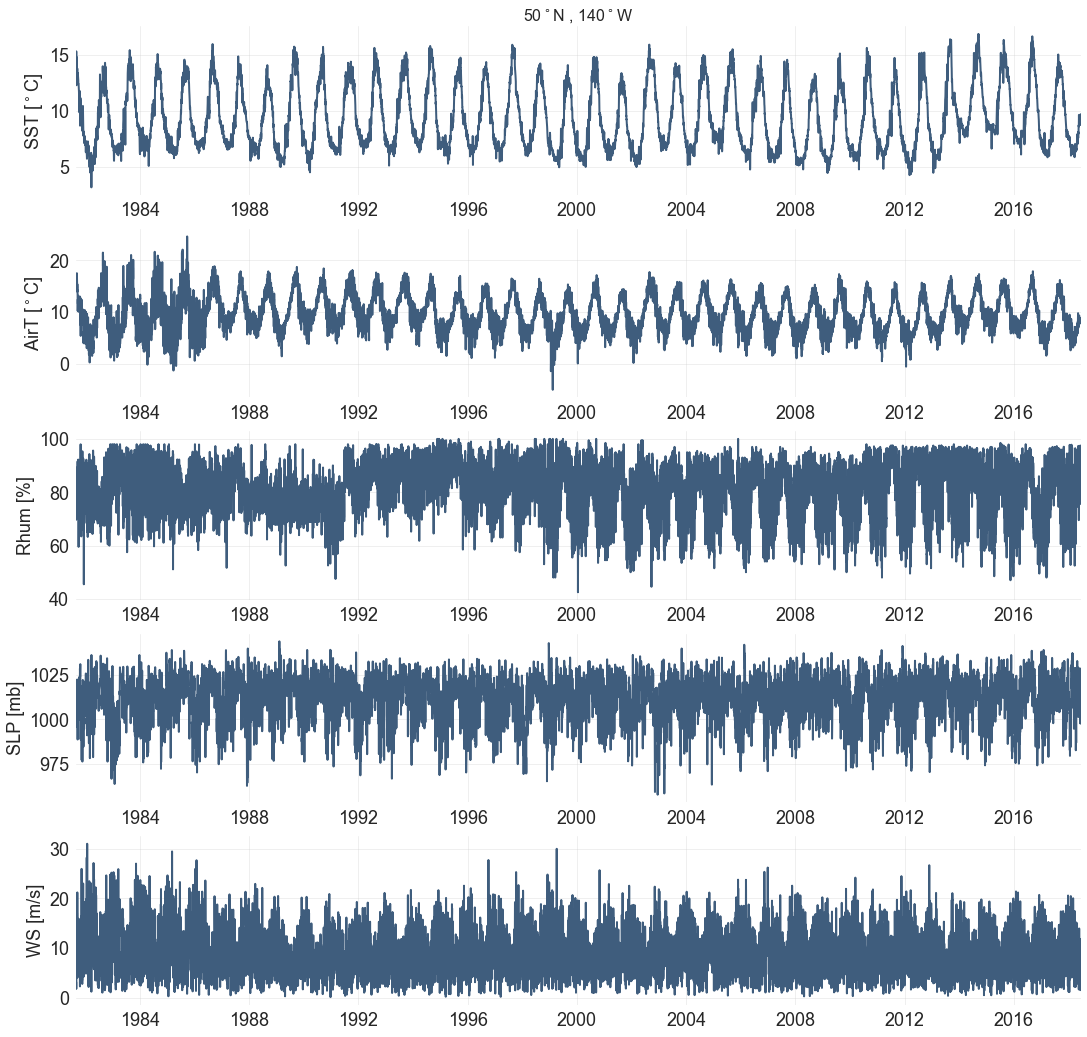

In [219]:
# Plot Time Series
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18)
plt.figure(figsize=(18,18))

# SST
ax = plt.subplot(511)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)  
ax.spines["left"].set_visible(False)  
ax.tick_params(axis=u'both', which=u'both', length=0)
plt.plot(sst_dates, sst,color="#3F5D7D", linewidth = 2)
plt.ylabel('SST [$^\circ$C]', size=18)
plt.xlim(sst_dates[0], sst_dates[-1])
plt.grid(True, alpha=0.3)
plt.title(lat + '$^\circ$N , ' + lon +'$^\circ$W', fontsize=16)

# Air Temperature
ax = plt.subplot(512)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)  
ax.spines["left"].set_visible(False)  
ax.tick_params(axis=u'both', which=u'both', length=0)
plt.plot(atmo_dates, airt,color="#3F5D7D", linewidth = 2)
plt.ylabel('AirT [$^\circ$C]', size=18)
plt.xlim(atmo_dates[0], atmo_dates[-1])
plt.grid(True, alpha=0.3)

# Relative Humidity
ax = plt.subplot(513)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)  
ax.spines["left"].set_visible(False)  
ax.tick_params(axis=u'both', which=u'both', length=0)
plt.plot(atmo_dates, rhum,color="#3F5D7D", linewidth = 2)
plt.ylabel('Rhum [%]', size=18)
plt.xlim(atmo_dates[0], atmo_dates[-1])
plt.grid(True, alpha=0.3)

# Sea Level Pressure
ax = plt.subplot(514)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)  
ax.spines["left"].set_visible(False)  
ax.tick_params(axis=u'both', which=u'both', length=0)
plt.plot(atmo_dates, slp,color="#3F5D7D", linewidth = 2)
plt.ylabel('SLP [mb]', size=18)
plt.xlim(atmo_dates[0], atmo_dates[-1])
plt.grid(True, alpha=0.3)

# Wind Speed
ax = plt.subplot(515)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)  
ax.spines["left"].set_visible(False)  
ax.tick_params(axis=u'both', which=u'both', length=0)
plt.plot(atmo_dates, ws,color="#3F5D7D", linewidth = 2)
plt.ylabel('WS [m/s]', size=18)
plt.xlim(atmo_dates[0], atmo_dates[-1])
plt.grid(True, alpha=0.3)


***
### Exploratory Data Anslysis
Let's look at how these variables are correlated and what meaningful relationships there might be.

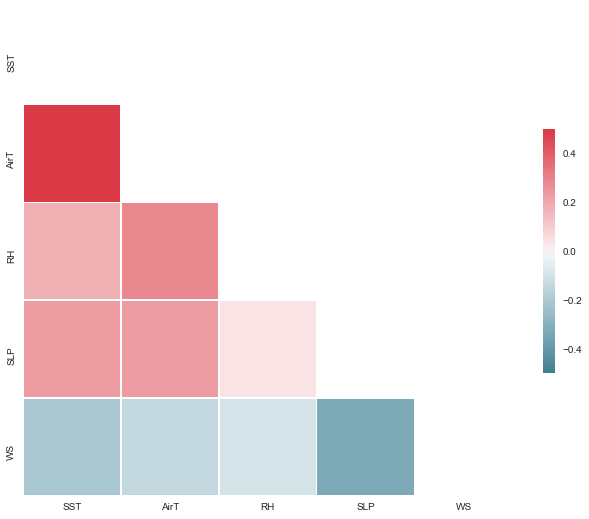

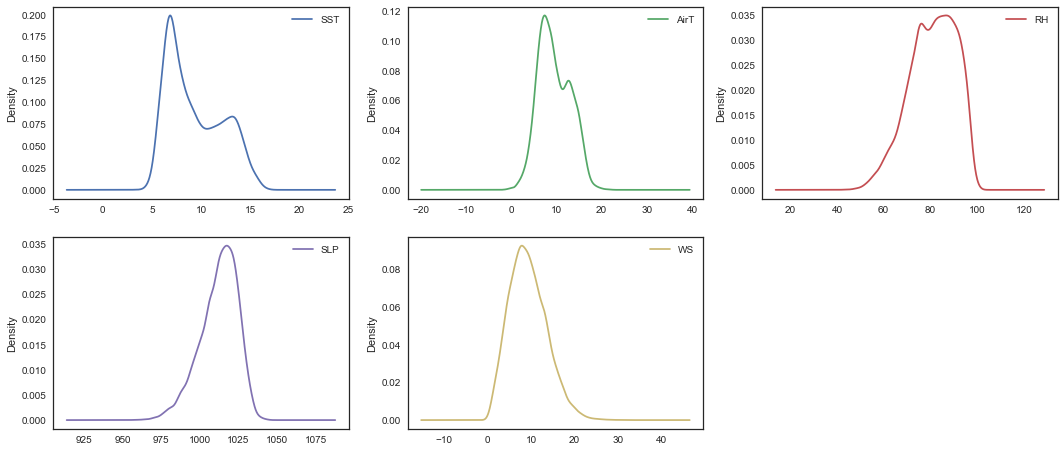

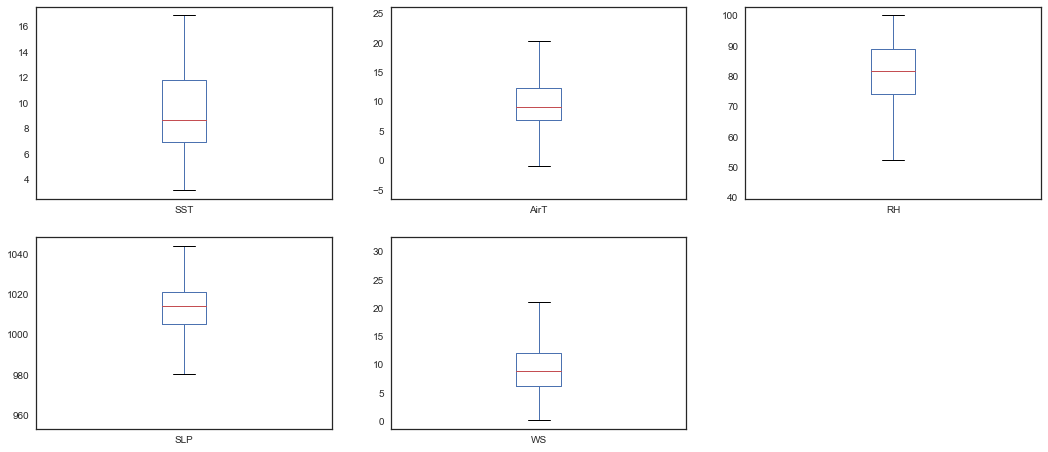

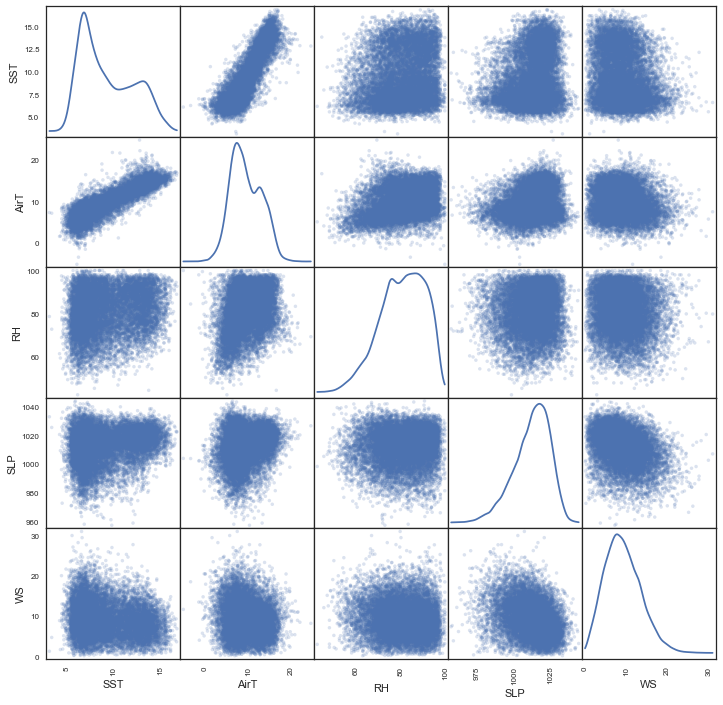

In [220]:
data = DataFrame(np.transpose(np.array([sst, airt, rhum, slp, ws])),columns=['SST','AirT','RH','SLP','WS'])

# Correlation matrix
sns.set(style="white")
corr = data.corr()
mask = np.zeros_like(corr, dtype=np.bool) # Generate a mask for the upper triangle
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True) # Generate a custom diverging colormap
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.5, vmin = -0.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

# Density
data.plot(kind='density',figsize=(18, 12), subplots=True, layout=(3,3), sharex=False)
plt.show()

# Box and Whiskers
data.plot(kind='box',figsize=(18, 12), subplots=True, layout=(3,3), sharex=False, sharey=False)
plt.show()

# Scatter Matrix 
pd.plotting.scatter_matrix(data, alpha=0.2, figsize=(12, 12), diagonal='kde')
plt.show()

**Let's loook at our data structure and check for missing values**

In [221]:
# Data = (timesteps, features)
data = DataFrame(np.transpose(np.array([sst, airt, rhum, slp, ws])),columns=['SST','AirT','RH','SLP','WS'])
print('data shape =',data.shape)
print (data.head())
print('')

# search for missing values
values = data.values
values = values.astype('float32')

missing = np.any(np.isnan(values))
finite = np.all(np.isfinite(values)) # determines whether the passed value is a finite number. 
print('Are there missing values in my data?..',missing)
print('Are my values finite?..', finite)

data shape = (13433, 5)
         SST       AirT         RH          SLP        WS
0  14.740000  16.160004  69.679993  1015.290039  3.181000
1  15.290000  16.040009  70.529999  1014.330017  1.823326
2  12.349999  15.930023  71.380005  1013.369995  2.280365
3  12.270000  15.809998  72.240005  1012.410034  3.976980
4  12.570000  15.699982  73.089996  1011.450012  5.928382

Are there missing values in my data?.. True
Are my values finite?.. False


**Oh no! There are missing values!**

For now let's just delete these rows to procede.

In [222]:
# Find index where there are nans
I = int(np.argwhere(np.isnan(data['RH'])))
print('index of missing RH values =',I)
print('data at nan index =',data['RH'][I])
print('nan value date =',atmo_dates[I])
print(data.iloc[I]) # nan value for just RH
print('')

J = int(np.argwhere(np.isnan(data['SLP'])))
print('index of missing SLP values =',J)
print('data at nan index =',data['SLP'][J])
print('nan value date =',atmo_dates[J])
print(data.iloc[J]) # there are nans for both slp and wind speed
print('Look! There is also a missing WS value.')
print('')

# Let's combine drop the combined indices
dp = [I,J]
test = data.drop(data.index[dp]) # drop rows with nans
print('new size of data with dropped nans =',test.shape)
print('clearn data: ')
print(data.iloc[dp])
print('')


missing = np.any(np.isnan(test))
finite = np.all(np.isfinite(test))
print('Are there missing values in my data?..',missing)
print('Are my values finite?..', finite)
print('If False and True, then we are good to procede!')

data = test
time = DataFrame(atmo_time)
time = time.drop(time.index[dp])


index of missing RH values = 9032
data at nan index = nan
nan value date = 2006-05-25
SST       7.260000
AirT      8.260010
RH             NaN
SLP     987.700012
WS        8.675716
Name: 9032, dtype: float32

index of missing SLP values = 7693
data at nan index = nan
nan value date = 2002-09-24
SST     13.809999
AirT    16.600006
RH      44.549988
SLP           NaN
WS            NaN
Name: 7693, dtype: float32
Look! There is also a missing WS value.

new size of data with dropped nans = (13431, 5)
clearn data: 
            SST       AirT         RH         SLP        WS
9032   7.260000   8.260010        NaN  987.700012  8.675716
7693  13.809999  16.600006  44.549988         NaN       NaN

Are there missing values in my data?.. False
Are my values finite?.. True
If False and True, then we are good to procede!


In [223]:
time = time.values
date = [date.fromordinal(tt) for tt in time]
date = np.array(date)

In [224]:
print(date)

[datetime.date(1981, 9, 1) datetime.date(1981, 9, 2)
 datetime.date(1981, 9, 3) ... datetime.date(2018, 6, 9)
 datetime.date(2018, 6, 10) datetime.date(2018, 6, 11)]


***
# Data Prep
1. Normalize features
2. Create lagged series
3. Divide data into a training and test set


### Normalize features

In [225]:
values = data.values
values = values.astype('float32') # ensure all data is float

# normalize features in range -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(values)

### Create lagged supervised series

In [226]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True): # 
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


lag = 50 # input sequence
n_features = 5

steps = 30 # forecast sequence
# frame as supervised learning
reframed = series_to_supervised(scaled, lag, steps)


print(reframed.head())
print('Size of supervised series =',reframed.shape,' = [#samlples, (n_features*lags + n_features*steps)]')
values = reframed.values

    var1(t-50)  var2(t-50)  var3(t-50)  var4(t-50)  var5(t-50)  var1(t-49)  \
50    0.692982    0.428765   -0.054609    0.334717   -0.804171    0.773392   
51    0.773392    0.420681   -0.025043    0.312586   -0.892260    0.343567   
52    0.343567    0.413273    0.004522    0.290455   -0.862606    0.331871   
53    0.331871    0.405187    0.034435    0.268326   -0.752526    0.375731   
54    0.375731    0.397776    0.064000    0.246197   -0.625914    0.673977   

    var2(t-49)  var3(t-49)  var4(t-49)  var5(t-49)     ...      var1(t+28)  \
50    0.420681   -0.025043    0.312586   -0.892260     ...       -0.154971   
51    0.413273    0.004522    0.290455   -0.862606     ...       -0.112573   
52    0.405187    0.034435    0.268326   -0.752526     ...       -0.127193   
53    0.397776    0.064000    0.246197   -0.625914     ...       -0.121345   
54    0.390367    0.093565    0.224068   -0.494806     ...       -0.133041   

    var2(t+28)  var3(t+28)  var4(t+28)  var5(t+28)  var1(t+29)

### Split data into test and train sets

In [227]:
## split into input and outputs
n_obs = lag * n_features
print('total number of n_obs (lags x features) =',n_obs)
print('')

train = values[:-(steps), :]
test = values[-steps:, :]
print('train = [#samles, (n_features*lags + n_features*steps)] =',train.shape)
print('test = [#samples, (n_features*lags + n_features*steps)] =',test.shape) 
print('')

xtrain, ytrain = train[:, :n_obs], train[:, -n_features] # train[:, -n_features]
xtest, ytest = test[:, :n_obs], test[:, -n_features] # test[:, -n_features]
print(xtrain.shape, ytrain.shape)
print('')


# reshape input to be 3D [samples, timesteps, features]
Xtrain = xtrain.reshape((xtrain.shape[0], lag, n_features))
Xtest = xtest.reshape((xtest.shape[0], lag, n_features))
print('**[samles, input sequence, features]**')
print('training set =',Xtrain.shape)
print('test set =', Xtest.shape)

total number of n_obs (lags x features) = 250

train = [#samles, (n_features*lags + n_features*steps)] = (13322, 400)
test = [#samples, (n_features*lags + n_features*steps)] = (30, 400)

(13322, 250) (13322,)

**[samles, input sequence, features]**
training set = (13322, 50, 5)
test set = (30, 50, 5)


## Define and fit LSTM
Fit and LSTM on the multivariate input data

- Define LSTM with 50 neurons in the first hidden layer and 1 neuron in the output layer for predicting pollution.
- Input shape is 1 time step with 9 features
- Use Mean Absolute Error (MSE) loss function and the efficient Adam vesion of stochastic graident descent
- The model will be fit for 50 training and test loss during training by setting the validation_data argument in the fit() funciton.

In [228]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam',metrics=['mse', 'accuracy'])
# fit network
history = model.fit(Xtrain, ytrain, epochs=10, batch_size=72, validation_data=(Xtest, ytest), verbose=2, shuffle=True)


Train on 13322 samples, validate on 30 samples
Epoch 1/10
 - 10s - loss: 0.1550 - mean_squared_error: 0.0404 - acc: 7.5064e-04 - val_loss: 0.1273 - val_mean_squared_error: 0.0212 - val_acc: 0.0000e+00
Epoch 2/10
 - 8s - loss: 0.1149 - mean_squared_error: 0.0228 - acc: 8.2570e-04 - val_loss: 0.1389 - val_mean_squared_error: 0.0251 - val_acc: 0.0000e+00
Epoch 3/10
 - 8s - loss: 0.1060 - mean_squared_error: 0.0194 - acc: 8.2570e-04 - val_loss: 0.1098 - val_mean_squared_error: 0.0180 - val_acc: 0.0000e+00
Epoch 4/10
 - 8s - loss: 0.1039 - mean_squared_error: 0.0188 - acc: 7.5064e-04 - val_loss: 0.1266 - val_mean_squared_error: 0.0216 - val_acc: 0.0000e+00
Epoch 5/10
 - 8s - loss: 0.1006 - mean_squared_error: 0.0176 - acc: 7.5064e-04 - val_loss: 0.1181 - val_mean_squared_error: 0.0194 - val_acc: 0.0000e+00
Epoch 6/10
 - 8s - loss: 0.0973 - mean_squared_error: 0.0165 - acc: 8.2570e-04 - val_loss: 0.0908 - val_mean_squared_error: 0.0119 - val_acc: 0.0000e+00
Epoch 7/10
 - 8s - loss: 0.0950 - 

## Run model diagnostics




dict_keys(['val_loss', 'val_mean_squared_error', 'val_acc', 'loss', 'mean_squared_error', 'acc'])


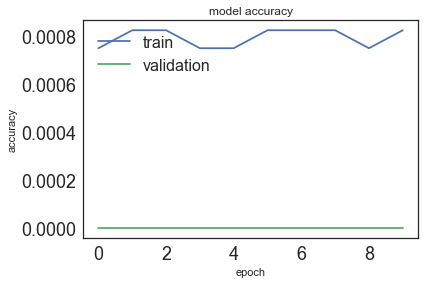

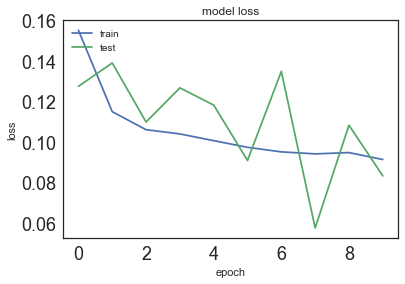

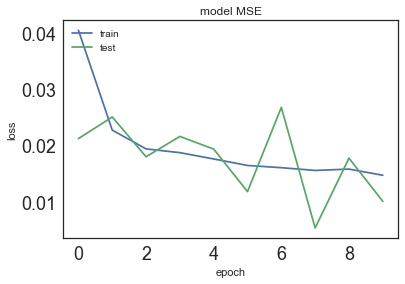

5
(30, 1)
Test RMSE: 0.689


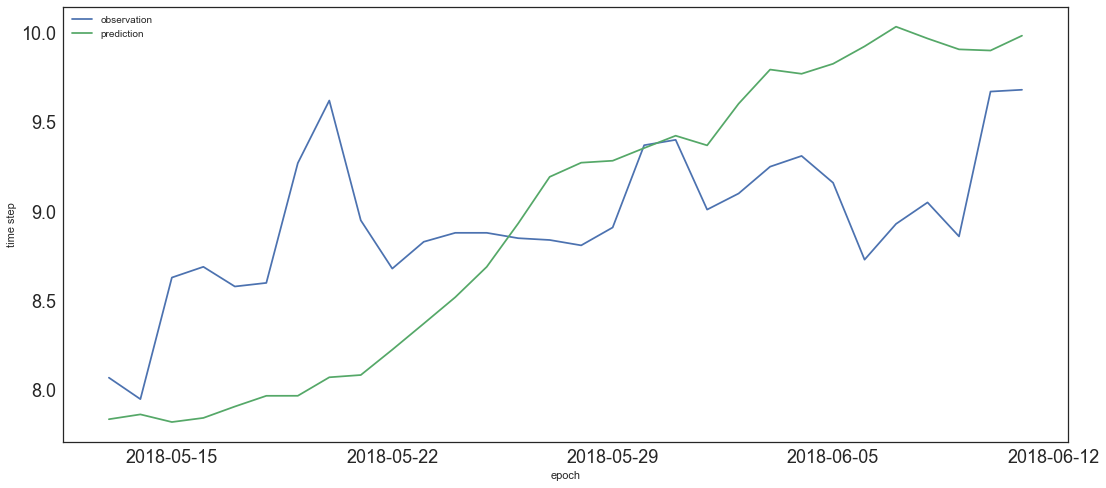

In [245]:
print(history.history.keys())
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18)

#  Summarize history for accuracy
plt.plot(history.history['acc'], label='')
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left',fontsize=16)
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left',fontsize=16)
plt.show()

# summarize history MSE
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model MSE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left',fontsize=16)
plt.show()

# make a prediction
Xtestt = Xtest.reshape((Xtest.shape[0], lag*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, Xtestt[:, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
ytesty = ytest.reshape((len(ytest), 1))
inv_y = concatenate((ytesty, Xtestt[:, -(n_features-1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# Plot prediction
yhat = model.predict(Xtest)
plt.figure(figsize=(18,8))
plt.plot(date[-steps:],inv_y, label='observation')
plt.plot(date[-steps:],inv_yhat, label='prediction')
plt.legend(loc='upper left',fontsize=16)
plt.ylabel('time step')
plt.xlabel('epoch')
print(n_features)
print(yhat.shape)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

- After the model is fit, we can forecast the entire test dataset
- Combine forecast with test dataset and invert the scaling. can also invert scaling on test dataset with expected SST numbers
- with forecast and actual values in the original scale, we can calculate an error score for the model. 
- in this case, the root mean squared error (RMSE) that gives error in the same units as the variable itself

(30,)


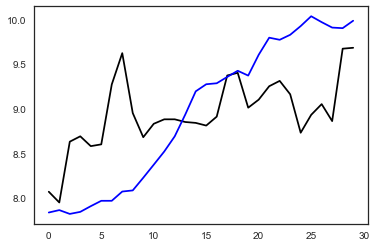

In [231]:
plt.plot(inv_y,color="black")
plt.plot(inv_yhat,color="blue")
print(inv_y.shape)

## Build LSTM with training set

## Evaluate Predictions 
- predict with test data
- compare predictions with observations
- calculate prediction errors

#### Compute SST climatology and marine heatwave thresholds
- Use the [*marineHeatWave*](https://github.com/ecjoliver/marineHeatWaves) module by Eric Oliver to calculate the daily seasonal SST climatology and MHW thresholds


In [232]:
print(sst_time.shape,sst.shape)

(13433,) (13433,)


In [233]:
mhw, clim = detect(sst_time, SST, climatologyPeriod=[1988,2017], 
       pctile=90, windowHalfWidth=5, smoothPercentile=True, 
       smoothPercentileWidth=31, minDuration=5, 
       joinAcrossGaps=True, maxGap=2, maxPadLength=False, 
       coldSpells=False, alternateClimatology=False)


sst_clim = clim['seas'] # seasonal climatology computed between 1988-2017
mhw_thres = clim['thresh'] # marine heatwave threshold computed as the 90th percentile from the seasonal climatology

#### Plot predictions on top of climatology and observations

ValueError: x and y must have same first dimension, but have shapes (352, 1) and (30,)

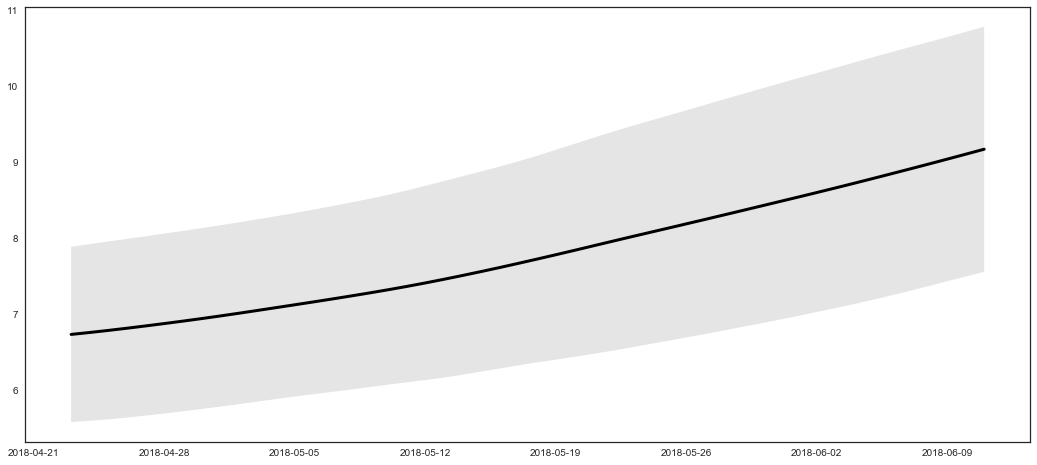

In [234]:
# Make Figure, Define Axis, Set Default Font Size
plt.figure(figsize=(18,8))
ax = plt.subplot(111)
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)



# Plot Climatology & Overlay Shading For Marine Heatwave Threshold
plt.plot(sst_dates[-50:],sst_clim[-50:],linewidth = 3, color="black",label="Climatology")
y1 = sst_clim[-50:]
y2 = mhw_thres[-50:]
dely = y1 - (y2-y1) # ad hoc way to find 10th percentile
plt.fill_between(sst_dates[-50:], dely, y2, facecolor='black', interpolate=True, alpha = 0.1,label = "10-90$^{th}$ percentile")

# Plot Observations & Predicted Values
plt.plot(time[len(time)-365+13:],inv_y, label='OISST', color="black",linewidth = 4, alpha=0.5,)
plt.plot(time[len(time)-365+13:],inv_yhat, label='LSTM',linewidth = 2, color='red') 

# Add Legend
plt.legend(loc="lower right", fontsize=14, frameon = False, ncol = 4)

# Make Figure Pretty
#plt.xlim(dates[nrow], dates[-window_size])
plt.title(lat + '$^\circ$N, ' + lon + '$^\circ$W  |  RMSE = %.3f$^\circ$C' % rmse,fontsize=18)
plt.ylabel('Sea Surface Temperature [$^\circ$C]',size=16)
plt.grid(True,alpha = 0.3)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 
ax.spines["left"].set_visible(False) 
ax.spines["bottom"].set_visible(False) 
ax.tick_params(axis=u'both', which=u'both',length=0)

# Save Figure Somewhere On Your Machine By Modifying The Path
# model architecture information is saved in the file naming convention
#os.chdir('/Users/hscannell/Desktop/Code/Marine_Heatwave_Prediction/LSTM/LSTM_figures') # <- change text in red to your path
#plt.savefig('LSTM_ws%.0f'% window_size + '_e%.0f' % epochs +'_bs%.0f' % batch_size +'_n%.0f' % nodes +'_'+ files[f][4:-3] +'.png', bbox_inches='tight')


**Credits:** The following code was created by adapting methods from the following blogs and websites:
- https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/
- https://machinelearningmastery.com/setup-python-environment-machine-learning-deep-learning-anaconda/

Marine Heatwave Dectection Module ([Hobday et al., 2016](https://www.sciencedirect.com/science/article/pii/S0079661116000057))
- https://github.com/ecjoliver/marineHeatWaves